In this notebook we want to combine the two classifiers that we saw previously into one final detector to detect all cyber attacks.

In [1]:
%load_ext autoreload

In [92]:
%autoreload
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

from intrusion_detection.load_input_data import load_df
from intrusion_detection.preprocessing.preprocessing import remove_dot_from_attack_type_classes
from intrusion_detection.target_definition import define_target
from intrusion_detection.preprocessing.pipeline import get_preprocessing_pipeline
from intrusion_detection.feature_selection.pipeline import get_feature_selection_pipeline
from intrusion_detection.modelling.cyber_attack_detector import CyberAttackDetector

In [93]:
df = load_df(
    file_path="../../../data/kddcup.data_10_percent",
    header_file="../../../data/kddcup.names"
)
df = remove_dot_from_attack_type_classes(df)

The pipeline that we are going to use is the one below:

In [94]:
from sklearn.pipeline import Pipeline
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from intrusion_detection.modelling.blender import Blender
from intrusion_detection.modelling.ddos_detector import DDOSDetector

numerical_columns = df.select_dtypes(exclude=object).columns.to_list()

df_target = define_target(df)
preprocessing_pipeline = get_preprocessing_pipeline()
feature_selection_pipeline = get_feature_selection_pipeline(numerical_columns)
ddos_detector_pipeline = Pipeline(
    [*feature_selection_pipeline.steps, ("model", DDOSDetector())]
)
cyber_attack_detector = CyberAttackDetector(
    preprocessing_pipeline=preprocessing_pipeline,
    ddos_detector_pipeline=ddos_detector_pipeline,
    anomaly_detection_pipeline=Blender(
        [HBOS(), IForest(n_jobs=1)],
    ),
)

cyber_attack_detector


CyberAttackDetector(anomaly_detection_pipeline=Blender(models=[HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5),
                                                               IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)]),
                    ddos_detector_pipeline=Pipeline(steps=[('drop_constant_features',
                                                            DropConstantFeature...
                                                                                  'dst_bytes'])),
                                                           ('frequency_encoder',
                                                            KeepInputFeaturesWrapper(rename_suffix='_freq',
                                                                                     wrapped_transformer=CountFrequencyEncoder(encoding_method='frequency',
                                                                                                                               unseen='encode'))),
                                                           ('replace_rare_categories',
                                                            RareLabelEncoder(n_categories=2,
                                                                             tol=0.01)),
                                                           ('one_hot_encoder',
                                                            OneHotEncoder()),
                                                           ('min_max_scaler',
                                                            SklearnTransformerWrapper(transformer=MinMaxScaler()))]))

From the graph above is not very clear, but the preprocessing pipeline feeds both the `anomaly_detection_pipeline` and the `ddos_detector_pipeline` and the `ddos_detector_pipeline` feeds the `anomaly_detection_pipeline`.

In the class `CyberAttackDetector` we first detect ddos attacks, then we use the instances that are detected as normal by the ddos attack detector to train the anomaly detector.

At prediction time, we consider as anomaly the predictions that are classifed as anomaly by either one of the two models.

## Training

In [95]:
target_columns = [col for col in df_target.columns if "target" in col]
X = df_target.drop(target_columns, axis=1)

In [96]:
from sklearn.model_selection import cross_val_predict
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    probas = cross_val_predict(cyber_attack_detector, X, cv=10, method="predict_proba")

## Model Evaluation

### Overall

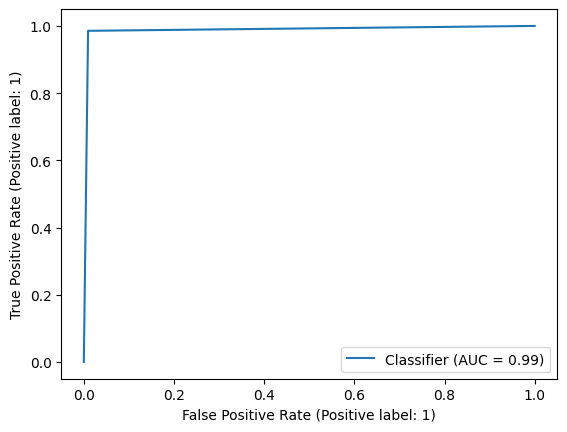

In [97]:
RocCurveDisplay.from_predictions(df_target[target_columns].sum(axis=1), probas[:, 1])

The results above should be better interpreted. As we have seen in the notebook where we have modelled DDOS Attacks, the model is very good at detecting DDOS Attacks, which are the anomaly with the highest frequency. The result above is driven mainly by the ability of the model to detects DDOS Attacks and it does not tell the full story on how the model performs on other attack types. This last point will be further investigated in the section below.

### Normal vs anomalies

Here we are going to focus on model performances with respect to the cyber attacks that are rare (so withouth the DDOS attacks `smurf` and `neptune`)

In [105]:
mask = ~df.attack_type.isin(["smurf", "neptune"])

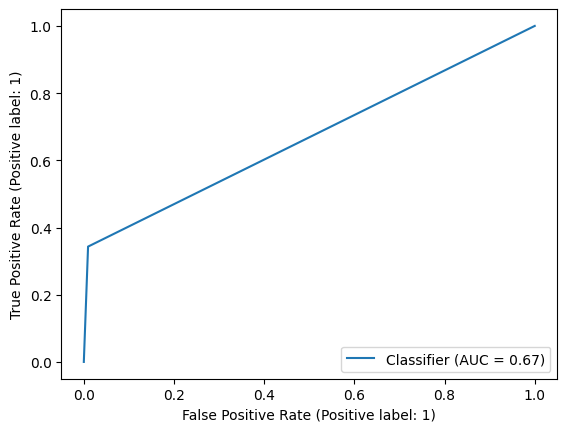

In [106]:
RocCurveDisplay.from_predictions(df_target["target_anomaly"][mask], probas[:,1][mask])

As we can see in the graph above, model performances here are much worse. We also notice a performance drop from the notebook where we focused on modelling anomalies.

This is because we have put the two models (DDOS + Anomaly) in cascade and the DDOS model introduces some extra false positives to the results of the anomaly detector.

Given that we have only used Unsupervised learning approaches, I would say that an AUC score of `0.67` is not that bad.

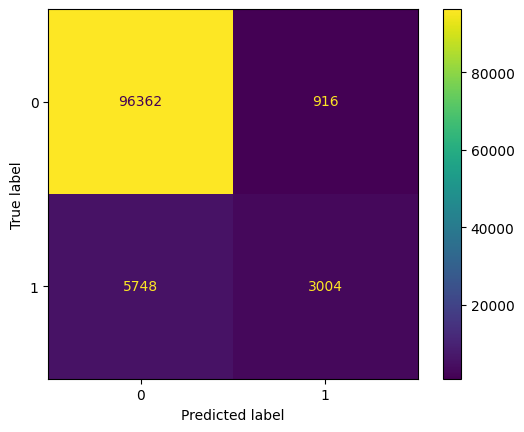

In [107]:
ConfusionMatrixDisplay.from_predictions(
   df_target["target_anomaly"][mask], probas[:,1][mask] > 0.5
)


In [108]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(df_target["target_anomaly"][mask], probas[:,1][mask] > 0.5)
precision = precision_score(df_target["target_anomaly"][mask], probas[:,1][mask] > 0.5)
recall = recall_score(df_target["target_anomaly"][mask], probas[:,1][mask] > 0.5)

display(Markdown(f"- f1_score = {f1:.3f}\n- precision = {precision:.3f}\n- recall = {recall:.3f}"))

- f1_score = 0.474
- precision = 0.766
- recall = 0.343

## Overall Results for all classes

In [109]:
prediction_by_attack_type = pd.DataFrame({"attack_type": df.attack_type.values, "classified_as_anomaly": (probas[:,1]> 0.5).astype(int)})

In [110]:
attack_anomaly_counts = pd.DataFrame(prediction_by_attack_type.value_counts()).rename(columns={0: "cross_counts"}).reset_index()
attack_counts = pd.DataFrame(prediction_by_attack_type.attack_type.value_counts()).rename(columns={"attack_type": "attack_counts"}).reset_index().rename(columns={"index": "attack_type"})
merged = attack_anomaly_counts.merge(attack_counts, on="attack_type")
merged["frac"] = merged.cross_counts / merged.attack_counts
merged

,attack_type,classified_as_anomaly,cross_counts,attack_counts,frac
0,smurf,1,280790,280790,1.000000
1,neptune,1,107176,107201,0.999767
2,neptune,0,25,107201,0.000233
3,normal,0,96362,97278,0.990584
4,normal,1,916,97278,0.009416
5,back,0,2203,2203,1.000000
6,satan,1,1401,1589,0.881687
7,satan,0,188,1589,0.118313
8,ipsweep,0,1164,1247,0.933440
9,ipsweep,1,83,1247,0.066560


<AxesSubplot: xlabel='frac', ylabel='attack_type'>

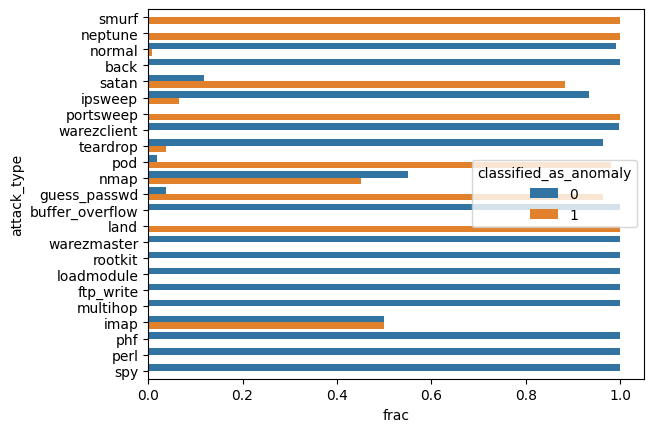

In [111]:
sns.barplot(data=merged, x="frac", y="attack_type", hue="classified_as_anomaly")

In the graph above we see how correct and wrong predictions are spread across different attack types. Notice that the results are normalized by the number of instances for that attack, so the blue and orange lines for each attack sum to 1.

Similarly to what we have seen in the first cases, the model is making relatively few false positives, moreover using the two models in cascade seem to improve the number of false positives. Here we see that the composite model is able to detect DDOS attacks very well and also other attacks like `satan`, `guess_password`, `land`, `portsweep`. The model fails at detecting many others classes like `warezclient` or `back`. If I had more time to spare, I would play with other unsupervised learning tecniques and I would try to improve the detection of those other classes.

Given that for this exercise we only used unsupervised approaches, I am quite satisfied with the results.